In [1]:
import sys
import os
import numpy as np
import xarray as xr
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.neuralnet import DEFAULT_FIT
from Hybrid.dataprep import default_prep, generate_balanced_kfold, THREEFOLD_DIVISION
from Hybrid.interpretation import combine_input_output, composite_extremes, model_to_submodel, order_by_hierachical_clustering, gradient, kernel_shap

2022-01-27 09:14:45.802080: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-27 09:14:45.802103: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
focus_class = -1 # Index of the class to be scored
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
#name = 'tg-ex-q0.75-21D_ge7D_sep12-15'
prepared_data, constructor = default_prep(predictandname=name, npreds = 4, use_jmeasure=False, focus_class = focus_class)

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler


Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
2022-01-27 09:14:49.472453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-27 09:14:49.472474: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-27 09:14:49.472490: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104): /proc/driver/nvidia/version does not exist
2022-01-27 09:14:49.472657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, reb

In [3]:
# Training the model and generating predictions
model = constructor.fresh_model()
model.fit(x = prepared_data.neural.trainval_inputs, y=prepared_data.neural.trainval_output, validation_split = 0.33, **DEFAULT_FIT)
preds_test = model.predict(x = prepared_data.neural.test_inputs)
preds_trainval = model.predict(x = prepared_data.neural.trainval_inputs)

2022-01-27 09:14:51.586467: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-27 09:14:51.598756: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3591580000 Hz


Epoch 1/200
41/41 [==============================] - 0s 4ms/step - loss: 0.7274 - accuracy: 0.5498 - brier: 0.2604 - val_loss: 0.7850 - val_accuracy: 0.4826 - val_brier: 0.2887
Epoch 2/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7185 - accuracy: 0.5513 - brier: 0.2562 - val_loss: 0.7702 - val_accuracy: 0.5016 - val_brier: 0.2828
Epoch 3/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.5964 - brier: 0.2409 - val_loss: 0.7401 - val_accuracy: 0.5205 - val_brier: 0.2702
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6377 - accuracy: 0.6617 - brier: 0.2187 - val_loss: 0.7040 - val_accuracy: 0.5394 - val_brier: 0.2547
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5975 - accuracy: 0.7006 - brier: 0.2003 - val_loss: 0.6756 - val_accuracy: 0.5726 - val_brier: 0.2423
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5706 - accuracy: 0.7348 - brier: 0.1883 

In [4]:
# Gathering outputs
feature_inputs = np.concatenate([prepared_data.neural.trainval_inputs[0],prepared_data.neural.test_inputs[0]])
log_of_raw = np.concatenate([prepared_data.neural.trainval_inputs[-1],prepared_data.neural.test_inputs[-1]])
index = prepared_data.crossval.X_trainval.index.append(prepared_data.crossval.X_test.index)
outpos = combine_input_output(model = model, feature_inputs = feature_inputs, 
                              log_of_raw = log_of_raw , target_class_index = -1, 
                              feature_names = prepared_data.raw.predictors.columns.to_flat_index(), index = index)
outneg = combine_input_output(model = model, feature_inputs = feature_inputs,
                              log_of_raw = log_of_raw, target_class_index = 0, 
                              feature_names = prepared_data.raw.predictors.columns.to_flat_index(), index = index)
outpos['change'] = outpos['f_cor'] - outpos['f_raw']
outneg['change'] = outneg['f_cor'] - outneg['f_raw']
outpos['perc_change'] = (outpos['f_cor'] - outpos['f_raw']) / outpos['f_raw'] * 100
outneg['perc_change'] = (outneg['f_cor'] - outneg['f_raw']) / outneg['f_raw'] * 100

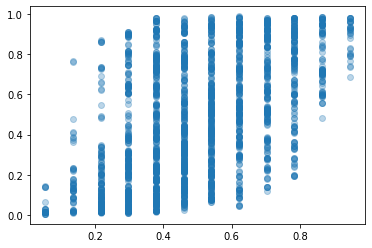

In [9]:
plt.scatter(outpos['f_raw'], outpos['f_cor'], alpha = 0.3) # The amount of change is less at the tails (already certain)

* Changes to f_raw are least present at the extremes (1,0). Inbetween a lot is possible.

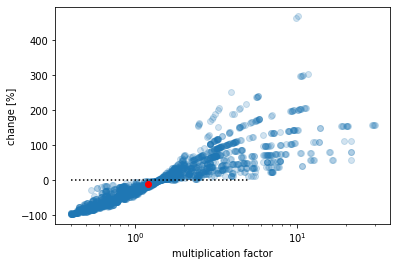

In [29]:
plt.scatter(outpos['multi'], outpos['perc_change'], alpha = 0.2)
plt.plot([0.4,5],[0,0], ls = ':', color = 'black')
plt.scatter(outpos['multi'].median(), outpos['perc_change'].median(), color = 'red')
plt.xscale('log')
plt.xlabel('multiplication factor')
plt.ylabel('change [%]')
plt.show()

* Especially multiplications below 1 lead to a reduction that is larger (probably because the negative class is scaled up heavily). The general pattern for this target is also an overall decrease of the positive class because it is overforecast.
* Same curve is present for the negative class (because of course there is a limit to multiplications >1.)

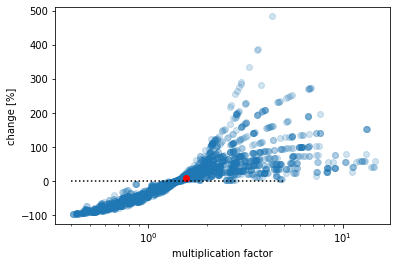

In [32]:
plt.scatter(outneg['multi'], outneg['perc_change'], alpha = 0.2)
plt.plot([0.4,5],[0,0], ls = ':', color = 'black')
plt.scatter(outneg['multi'].median(), outneg['perc_change'].median(), color = 'red')
plt.xscale('log')
plt.xlabel('multiplication factor')
plt.ylabel('change [%]')
plt.show()

In [10]:
seasonal_mean = outpos[['f_raw','multi','f_cor']].groupby(outpos.index.get_level_values('time').year).mean()
seasonal_classification,_ = generate_balanced_kfold(outpos['f_raw'])

generating test group
generating trainval groups


In [12]:
seasonal_classification.unique()

array([10, 20, 30])

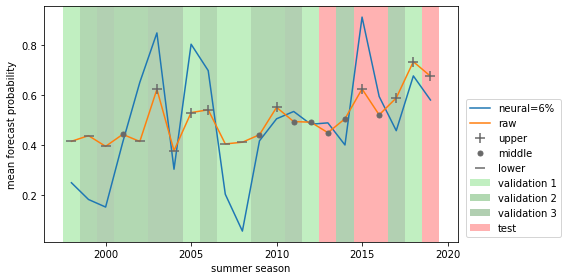

In [82]:
fig, ax1 = plt.subplots(figsize = (8,4))
ax1.plot(seasonal_mean[['f_cor','f_raw']], label = ['neural=6%','raw'])
for i, name, marker in zip(seasonal_classification.unique()[::-1],('upper','middle','lower'),('+','.','_')):
    belong_to_tercile = seasonal_mean.loc[seasonal_classification.values == i,'f_raw']
    ax1.scatter(x = belong_to_tercile.index, y = belong_to_tercile, label = name, marker = marker, s = 100, color = 'dimgrey', zorder = 20)

foldnames = pd.Series(['validation 1','validation 2','validation 3','test'], index = THREEFOLD_DIVISION.unique())
foldcolors = pd.Series(['limegreen','green','darkgreen','red'], index = foldnames.index)
for val,year in zip(THREEFOLD_DIVISION, THREEFOLD_DIVISION.index):
    ax1.axvspan(year-0.5, year+0.5, facecolor=foldcolors.loc[val], alpha = 0.3)

extra_items = [Patch(facecolor=foldcolors.loc[i],label=foldnames.loc[i], alpha = 0.3) for i in foldnames.index]

ax1.legend(handles = ax1.get_legend_handles_labels()[0] + extra_items, loc=(1.02,0.02))
ax1.set_xlabel('summer season')
ax1.set_ylabel('mean forecast probability')
plt.tight_layout()
plt.savefig(os.path.expanduser('~/Pictures/crossval_division.pdf'))

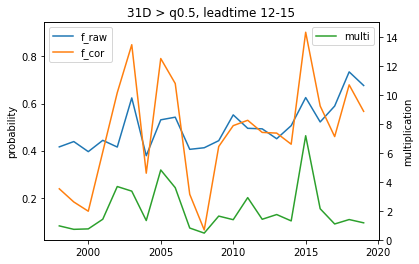

In [33]:
fig, ax1 = plt.subplots()
ax1.plot(seasonal_mean[['f_raw','f_cor']], label = ['f_raw','f_cor'])
ax1.set_ylabel('probability')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(seasonal_mean['multi'], label = 'multi', color = 'tab:green')
ax2.set_ylim(0,15)
ax2.set_ylabel('multiplication')
ax2.legend()
ax1.set_title('31D > q0.5, leadtime 12-15')
plt.show()

In [5]:
# Correlation matrices. Which predictors correlate best with the corrections?
# Perhaps linear correlation is not the best, as we have a non-linear method.
from scipy.stats import spearmanr

In [6]:
pearson = np.corrcoef(outpos.values.T)
spearman = spearmanr(outpos.values, axis = 0)[0]
with_multi = pd.DataFrame({'pearson':pearson[1,:],'spearman':spearman[1,:]}, index = outpos.columns)
with_raw = pd.DataFrame({'pearson':pearson[0,:],'spearman':spearman[0,:]}, index = outpos.columns)
#plt.imshow(cormat)

In [7]:
pearson = np.corrcoef(outneg.values.T)
spearman = spearmanr(outneg.values, axis = 0)[0]
with_multi_neg = pd.DataFrame({'pearson':pearson[1,:],'spearman':spearman[1,:]}, index = outneg.columns)
with_raw_neg = pd.DataFrame({'pearson':pearson[0,:],'spearman':spearman[0,:]}, index = outneg.columns)

In [8]:
pd.concat([with_multi,with_multi_neg], axis = 1, keys = ['pos','neg'])

pos                 neg          
                                  pearson  spearman   pearson  spearman
f_raw                           -0.026896  0.036576  0.080622  0.029848
multi                            1.000000  1.000000  1.000000  1.000000
f_cor                            0.622184  0.838939  0.639480  0.834650
(sst_nhplus, 21, 4, spatcov)     0.484534  0.680523 -0.604947 -0.671056
(sst, 21, 3, mean)              -0.260272 -0.130618  0.143817  0.142517
(t850_nhblock, 21, 0, mean)      0.348288  0.356024 -0.304062 -0.343979
(swvl13_europe, 11, 0, spatcov) -0.286267 -0.334274  0.252575  0.350234
change                           0.751875  0.973567  0.690373  0.973779
perc_change                      0.723218  0.971870  0.599087  0.942987

In [9]:
pd.concat([with_multi,with_raw], axis = 1, keys = ['multi','raw']).loc[:,(slice(None),'spearman')]

,multi,raw
,spearman,spearman
f_raw,0.036576,1.000000
multi,1.000000,0.036576
f_cor,0.838939,0.528595
"(sst_nhplus, 21, 4, spatcov)",0.680523,0.224952
"(sst, 21, 3, mean)",-0.130618,0.333485
"(t850_nhblock, 21, 0, mean)",0.356024,0.093067
"(swvl13_europe, 11, 0, spatcov)",-0.334274,0.111409
change,0.973567,-0.091585
perc_change,0.971870,0.027688


* So it is interesting that there are variables with a different relation to the correction than the the raw forecast probability. This means that they are not just used for negative moderation (lowering when values are high, heightening when values are low). SSt and swvl13 are such examples.
* It can also be concluded that the variables actually have weak links to the raw forecast probabilities (and presumably also to the observation).
* The fact that the first strong factor is really related to the multi and less (but still positive) to the raw values, might indicate that this is an underexpressed link.

In [5]:
composite_extremes(outpos,level = 0.1, columnname = 'multi')

,0.1,neutral,0.9
f_raw,0.451280,0.505894,0.495377
multi,0.426938,1.266628,10.165992
f_cor,0.085807,0.458146,0.930578
"(sst_nhplus, 21, 4, spatcov)",-1.206372,0.097425,1.004742
"(sst, 31, 3, mean)",0.036693,0.039241,-1.019467
"(t850_nhblock, 21, 0, mean)",-0.625399,0.029702,0.717297
"(swvl13_europe, 11, 0, spatcov)",0.649271,-0.045535,-0.721347
change,-0.365473,-0.047748,0.435201
perc_change,-83.361053,-7.176336,111.699448


In [6]:
composite_extremes(outpos, columnname = 'f_raw', level = 0.1)

,0.1,neutral,0.9
f_raw,0.177731,0.510644,0.886443
multi,1.595900,2.184299,1.219280
f_cor,0.187926,0.479525,0.782135
"(sst_nhplus, 21, 4, spatcov)",-0.253587,0.059312,0.576203
"(sst, 31, 3, mean)",-0.534027,-0.075995,0.885637
"(t850_nhblock, 21, 0, mean)",-0.241903,0.052037,0.216948
"(swvl13_europe, 11, 0, spatcov)",-0.043473,-0.077744,0.487364
change,0.010195,-0.031119,-0.104308
perc_change,6.936947,-3.422379,-11.836923


* The changing scales, sometimes opposite signs make me think about the association direction in scatterplots. A factor usually associated with higher probabilities, need not be in the same way be associated to overforcasting.
* plus isn't it possible to show the bivariate plot (combination of empirical factors leading to higher) for raw probabilities, and to show the same for with heightened corrected probabilities?

Text(0.5, 1.0, 'color = p_post-processed')

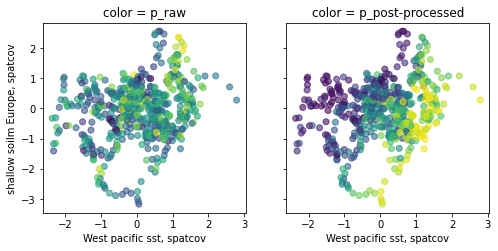

In [11]:
fig,axes = plt.subplots(ncols=2, squeeze = False, sharey = True, figsize = (8,3.5))
axes[0,0].scatter(x = outpos[('sst_nhplus', 21, 4, 'spatcov')], y = outpos[('swvl13_europe', 11, 0, 'spatcov')], alpha = 0.2, c = outpos[('f_raw')])
axes[0,1].scatter(outpos[('sst_nhplus', 21, 4, 'spatcov')],outpos[('swvl13_europe', 11, 0, 'spatcov')], alpha = 0.2, c = outpos[('f_cor')])

axes[0,0].set_ylabel('shallow soilm Europe, spatcov')
axes[0,0].set_xlabel('West pacific sst, spatcov')
axes[0,1].set_xlabel('West pacific sst, spatcov')

axes[0,0].set_title('color = p_raw')
axes[0,1].set_title('color = p_post-processed')

### Explanation of situations.
I.e. a grouping of the XAI explanations.

In [7]:
inpgrad_full = gradient(model=model, feature_inputs = , additional_inputs = np.concatenate([logforc_trainval,logforc_test]), times_input = True)
inpgrad_full = pd.DataFrame(inpgrad_full, index = X_trainval.index.append(X_test.index), columns = X_trainval.columns)
inpgrad_full = order_by_hierachical_clustering(inpgrad_full)

NameError: name 'features_trainval' is not defined

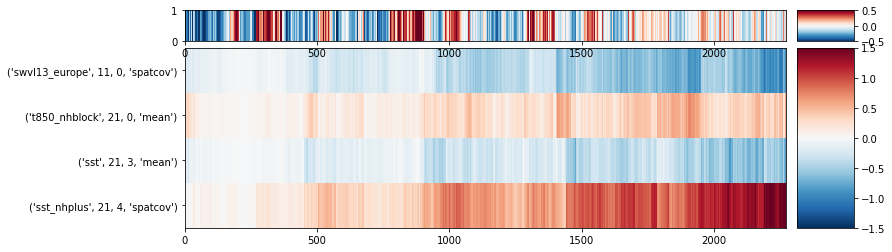

In [66]:
fig = plt.figure(figsize=(12,4), facecolor = 'white')
gs1 = GridSpec(nrows = 6, ncols = 10, hspace=0.2)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

expl = ax_expl.pcolor(inpgrad_full.T.values, vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(inpgrad_full.columns)+0.5, 1))
ax_expl.set_yticklabels(inpgrad_full.columns.to_flat_index().values)
cor = ax_cor.pcolor(outpos[['realchange']].reindex(inpgrad_full.index).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
fig.colorbar(expl, cax = ax_cbar_expl)
fig.colorbar(cor, cax = ax_cbar_cor)

This exists of explanations of the final outcome. So probably we get relation to the heat in general too, which might explain big corrections at very neutral explanation values. Perhaps submodel input times gradient is more informative.

In [8]:
submodel = model_to_submodel(model, exp_of_log_of_multiplier=True)

inpgrad_sub = gradient(model=submodel, feature_inputs = feature_inputs, times_input = True)
inpgrad_sub = pd.DataFrame(inpgrad_sub, index = index, columns = prepared_data.crossval.X_trainval.columns)
inpgrad_sub = order_by_hierachical_clustering(inpgrad_sub)

exp_values, shap_sub = kernel_shap(model=submodel, feature_inputs = feature_inputs, to_explain = slice(None), target_class = 1, shapkwargs = {'silent':True})
shap_sub = pd.DataFrame(shap_sub, index = index, columns = prepared_data.crossval.X_trainval.columns)
shap_sub = order_by_hierachical_clustering(shap_sub)

more than 300 samples detected, summarizing background dataset with shap.kmeans


In [12]:
inp = pd.DataFrame(feature_inputs, index = index, columns = prepared_data.crossval.X_trainval.columns)

array([[<AxesSubplot:title={'center':"('sst_nhplus', 21, 4, 'spatcov')"}>,
        <AxesSubplot:title={'center':"('sst', 31, 3, 'mean')"}>],
       [<AxesSubplot:title={'center':"('t850_nhblock', 21, 0, 'mean')"}>,
        <AxesSubplot:title={'center':"('swvl13_europe', 11, 0, 'spatcov')"}>]],
      dtype=object)

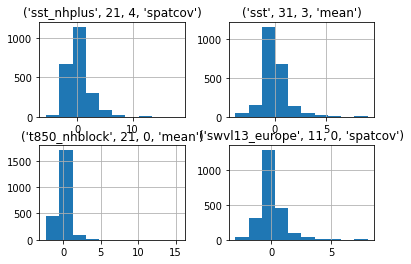

In [9]:
shap_sub.hist()

In [33]:
submodel.predict(feature_inputs)

array([[5.217463  , 0.5254579 ],
       [5.2583714 , 0.5235931 ],
       [5.296498  , 0.5218906 ],
       ...,
       [3.1280785 , 0.7091687 ],
       [2.9553962 , 0.74532   ],
       [2.9735682 , 0.74119914]], dtype=float32)

In [29]:
shap_sub.iloc[:,0].argmax()

408

In [30]:
submodel.predict(feature_inputs[[408],:])

array([[ 0.49773717, 18.133993  ]], dtype=float32)

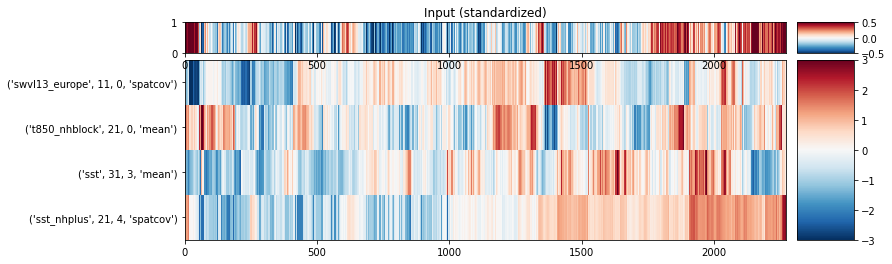

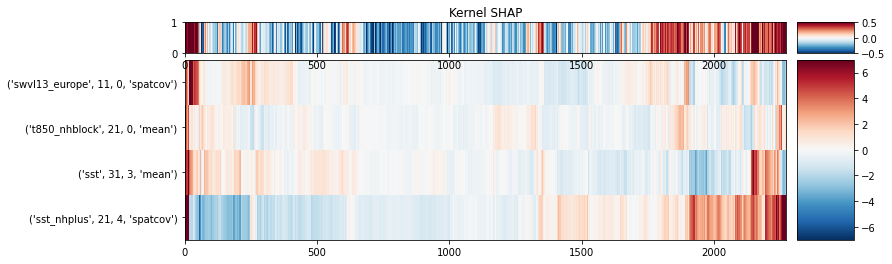

In [15]:
#order = inpgrad_sub.index
order = shap_sub.index
response = 'change'
#response = 'perc_change'

fig = plt.figure(figsize=(12,4), facecolor = 'white')
gs1 = GridSpec(nrows = 6, ncols = 10, hspace=0.2)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

# Input * gradient
#expl = ax_expl.pcolor(inpgrad_sub.reindex(order).T.values, vmin = -10, vmax = 10, cmap = 'RdBu_r')
#ax_expl.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
#ax_expl.set_yticklabels(inpgrad_sub.columns.to_flat_index().values)
#cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
#ax_cor.set_title('Input x gradient')
#fig.colorbar(expl, cax = ax_cbar_expl)
#fig.colorbar(cor, cax = ax_cbar_cor)

# Only input
expl = ax_expl.pcolor(inp.reindex(order).T.values, vmin = -3, vmax = 3, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_expl.set_yticklabels(inp.columns.to_flat_index().values)
cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_title('Input (standardized)')
fig.colorbar(expl, cax = ax_cbar_expl)
fig.colorbar(cor, cax = ax_cbar_cor)

#Kernel SHAP

fig = plt.figure(figsize=(12,4), facecolor = 'white')
gs1 = GridSpec(nrows = 6, ncols = 10, hspace=0.2)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

expl = ax_expl.pcolor(shap_sub.reindex(order).T.values, vmin = -7, vmax = 7, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(shap_sub.columns)+0.5,1))
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values)
cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_title('Kernel SHAP')
fig.colorbar(expl, cax = ax_cbar_expl)
fig.colorbar(cor, cax = ax_cbar_cor)